# Creating a volatility signature plot for a highly-liquid asset
This notebook aims to create a volatility signature plot for AAPL. A volatility signature plot is a graphical tool used in high-frequency data analysis to assess the impact of sampling frequency on realised volatility estimates.

## Intuition and purpose of RV, vs Integrated Variance/Volatility
- In quantitative finance, we often model log prices \$\displaystyle{p_t=log(P_t)}$ as a stochastic process, for example:

$$
dp_t = \mu_t dt + \sigma_t dW_t
$$

- If you integrate the instantaneous variance \$\displaystyle{\sigma^2}$ over time, you get:

$$
\text{Integrated Variance}_{[0,7]} = \int_0^T \sigma_t^2 dt
$$

- This is the true underlying variance of returns over the period, \$\displaystyle{[0,7]}$

Since we don't observe \$\displaystyle{\sigma_t}$, we approximate the integrated variance using discrete high-frequency data:

$$
\text{Realised Variaiance} = \sum_{i=1}^n r_i^2
$$

- As sampling frequency increases, i.e. \$\displaystyle{\Delta t \rightarrow 0}$, the sum of squared returns converges in probability to integrated variance

- However, because of market microstructure noise, which inclues: bid-ask bounce, discreteness of price changes, latency, liquidity issues, etc., these effects introduce spurious high-frequency volatility, inflating squared returns and thus realised variance
- Therefore, it is a misrepresentation of true volatility as integrated volatility is a theoretical construct of continuous time finance that represents true underlying variance

- High-frequency realised variance overestimates it because:

$$
\text{Observed RV} = \text{True Integrated Variance} + \text{Microstructure Noise}
$$

- So when sampling too frequently, you're not just measuring volatility, you're also capturing microstructure noise


## How to run this notebook
- Set .env variable POLYGON_API_KEY="your_API_KEY", or
- Pull AAPL minutely data using the function argument pull_or_pickle="pickle" which unpickles `apple_minute_data.pkl`

## Imports - core functions are Pandas, NumPy and Matplotlib. 
- `dotenv` and `OS` correspond to fetching API key from `.env` variables
- `requests` is used for the API call

In [1]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
import requests
import matplotlib.pyplot as plt

## Sourcing and processing 1 min data for Apple stock
- I will use Polygon with my personal API key, you can generate a free API key on their website
- There will also be a pkl file `apple_minute_data.pkl` which you can load instead, by calling the function with the `pull_or_picke="pickle"` argument

In [2]:
def pull_aapl_minute(pull_or_pickle="pull"):
    if os.path.exists("apple_minute_data.pkl") and pull_or_pickle != "pull":
        return pd.read_pickle("apple_minute_data.pkl").between_time('09:30','16:00').dropna()

    else:
        load_dotenv()
        api_key = os.getenv("POLYGON_API_KEY")

        url = "https://api.polygon.io/v2/aggs/ticker/AAPL/range/1/minute/2025-04-05/2025-05-05"
        params = {
            "adjusted":"true",
            "sort":"asc",
            "limit":50000,
            "apiKey":api_key
        }

        response = requests.get(url,params=params)
        data = response.json()["results"]
        df = pd.DataFrame(data)
        df["t"] = pd.to_datetime(df["t"],unit="ms")
        df.set_index("t",inplace=True)
        df = df.between_time('09:30',"16:00")
        df = df[["c"]]
        df.rename(columns={"c":"Close"}, inplace=True)
        df.to_pickle("apple_minute_data.pkl")
        return df.dropna()

In [3]:
data = pull_aapl_minute(pull_or_pickle="pickle")

## Data Preprocessing, \$\displaystyle{R^2}$ calculation, and daily realised volatility computation
- Resampling to 1, 5, 15, 60 minute intervals

In [4]:
frequency_intervals = {1: "1min", 5: "5min", 15: "15min", 30:"30min",60: "1h",120:"2h"}
daily_realised_volatility = pd.DataFrame()

for interval, resampling_interval in frequency_intervals.items():
    # Resample to the desired interval using last()
    resampled_series = data["Close"].resample(resampling_interval).last()
    # Compute squared log returns, drop NaNs
    log_returns = np.log(resampled_series / resampled_series.shift(1))
    r2 = (log_returns ** 2).dropna()
    # Resample to daily and sum
    daily_sum = r2.resample("1D").sum()
    # Store in DataFrame with daily index
    daily_realised_volatility[str(interval)] = daily_sum

# Ensure no NaNs remain (optional: forward-fill or drop)
daily_realised_volatility = daily_realised_volatility.fillna(0)

## Calculating annualised volatility
- The following formula was used after resampling to daily realised volatility
- For simplicity, I used `mean()`, however outliers may skew the results.

$$
RV_{\text{annualised}} = 100 \times \sqrt{252\times \sum R_t^2}
$$

- The idea is that squared returns provide a proxy for volatility. This approach follows the framework of Anderson et al. (2003), who formalised realised variance as a non-parametric estimator of integrated volatility in high-frequency data.

In [5]:
mean_rvs = daily_realised_volatility.mean()
result = mean_rvs.to_dict()
result = {int(frequency): mean_rv for frequency, mean_rv in result.items()}
mean_annual_vols = {frequency: 100 * np.sqrt(252 * mean_rv) for frequency, mean_rv in result.items()}

In [6]:
x = list(mean_annual_vols.keys())
y = pd.Series(mean_annual_vols.values())
y

0    43.588985
1    39.843498
2    38.158909
3    34.611020
4    31.494590
5    29.962659
dtype: float64

## Visualisation
- Below is the plotted Volatility Signature Plot

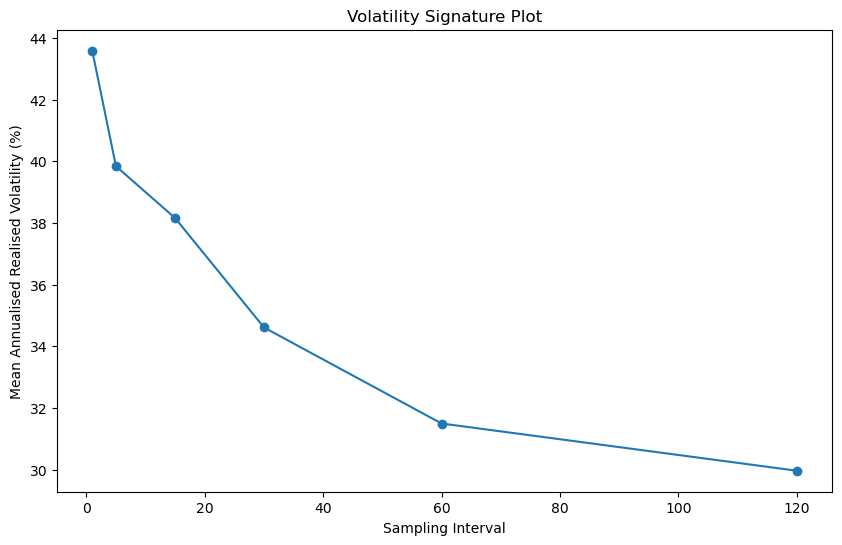

In [7]:
plt.figure(figsize=(10,6))
plt.plot(x,y,marker='o')
plt.title("Volatility Signature Plot")
plt.xlabel("Sampling Interval")
plt.ylabel("Mean Annualised Realised Volatility (%)")
plt.show()

## Conclusion
- We can conclude that as the sampling interval increases, realised volatility also does, however this does not necessarily reflected integrated volatility
- A trade-off can be seen: using higher frequency data, observed volatility is higher due to noise influence; using lower frequency data, observed volatility is underestimated. It is best to use medium frequency data (5-15 minutes) to have a *true signal*

## References
- Torben Andersen; Tim Bollerslev; Francis Diebold and Paul Labys, (2003), Modeling and Forecasting Realized Volatility, Econometrica, 71, (2), 579-625